# Chatbot de recommandation de films

Recommander des films selon un film référence ou selon une description.
Dans ce projet, vous devez utiliser un LLM open source pour la partie conversationnelle

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive')

dataset = pd.read_csv("/content/gdrive/MyDrive/ChatbotFilms/mpst_full_data.csv")

Mounted at /content/gdrive


## Preprocessing pour le synopsis

In [ ]:
!python -m spacy download en_core_web_sm

2023-11-30 09:22:18.900054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 09:22:18.900131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 09:22:18.900178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 09:22:18.913026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 09:22:21.039403: W tensorflow/compiler/

On tokenise les synopsis des films en utilisant deux tokeniseurs : treebank et spacy

In [ ]:
from nltk.tokenize import TreebankWordTokenizer
import spacy
from tqdm import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
tokenizer = nlp.tokenizer

def treebank_tokenize(text):
  # fonction qui tokenize avec le tokenizer TreeBank
  return(TreebankWordTokenizer().tokenize(text))

def spacy_tokenize(text):
  # fonction qui tokenize avec le tokenizer spacy
  text_tokenized = tokenizer(text)
  return [token.text for token in text_tokenized]

In [ ]:
dataset["synopsis_treebank"] = dataset['plot_synopsis'].progress_apply(treebank_tokenize)

100%|██████████| 14828/14828 [01:04<00:00, 230.92it/s]


In [ ]:
dataset["synopsis_spacy"] = dataset['plot_synopsis'].progress_apply(spacy_tokenize)

100%|██████████| 14828/14828 [01:02<00:00, 236.38it/s]


On effectue également le preprocessing suivant :
* Mettre le texte en minuscule
* Supprimer les stopwords (the, these, a, is, are, ...)  
* Ne garder que les tokens de plus de 2 caractères  
* Ne garder que les tokens qui sont alphabétiques

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

def preprocess(tokens):
    doc = nlp(' '.join(tokens))

    processed_tokens = [token.text.lower() for token in doc
                        if token.text.lower() not in STOP_WORDS and len(token.text) > 2 and token.is_alpha]

    return processed_tokens

In [ ]:
dataset["synopsis_preprocessed_spacy"] = dataset["synopsis_spacy"].progress_apply(preprocess)

  8%|▊         | 1259/14828 [05:01<58:51,  3.84it/s]  

In [ ]:
dataset["synopsis_preprocessed_treebank"] = dataset["synopsis_treebank"].progress_apply(preprocess)

## Preprocessing pour les tags

In [ ]:
dataset.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,synopsis_treebank,synopsis_spacy,tags_list,synopsis_preprocessed_spacy,synopsis_preprocessed_treebank
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"[Note, :, this, synopsis, is, for, the, orgina...","[Note, :, this, synopsis, is, for, the, orgina...","[cult, horror, gothic, murder, atmospheric]","[note, synopsis, orginal, italian, release, se...","[note, synopsis, orginal, italian, release, se..."
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,"[Two, thousand, years, ago, ,, Nhagruul, the, ...","[Two, thousand, years, ago, ,, Nhagruul, the, ...",[violence],"[thousand, years, ago, nhagruul, foul, sorcere...","[thousand, years, ago, nhagruul, foul, sorcere..."
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,"[Matuschek, 's, ,, a, gift, store, in, Budapes...","[Matuschek, 's, ,, a, gift, store, in, Budapes...",[romantic],"[matuschek, gift, store, budapest, workplace, ...","[matuschek, gift, store, budapest, workplace, ..."
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"[Glenn, Holland, ,, not, a, morning, person, b...","[Glenn, Holland, ,, not, a, morning, person, b...","[inspiring, romantic, stupid, feel-good]","[glenn, holland, morning, person, standards, w...","[glenn, holland, morning, person, standards, w..."
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[cruelty, murder, dramatic, cult, violence...","[cuban, man, named, tony, montana, pacino, cla...","[cuban, man, named, tony, montana, pacino, cla..."


Pour faciliter l'apprentissage pour la prédiction, on pourrait split la colonne tags en plusieurs colonnes.

In [ ]:
dataset['tags_list'] = dataset['tags'].apply(lambda x: x.split(','))
dataset.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,synopsis_treebank,synopsis_spacy,tags_list,synopsis_preprocessed_spacy,synopsis_preprocessed_treebank
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"[Note, :, this, synopsis, is, for, the, orgina...","[Note, :, this, synopsis, is, for, the, orgina...","[cult, horror, gothic, murder, atmospheric]","[note, synopsis, orginal, italian, release, se...","[note, synopsis, orginal, italian, release, se..."
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,"[Two, thousand, years, ago, ,, Nhagruul, the, ...","[Two, thousand, years, ago, ,, Nhagruul, the, ...",[violence],"[thousand, years, ago, nhagruul, foul, sorcere...","[thousand, years, ago, nhagruul, foul, sorcere..."
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,"[Matuschek, 's, ,, a, gift, store, in, Budapes...","[Matuschek, 's, ,, a, gift, store, in, Budapes...",[romantic],"[matuschek, gift, store, budapest, workplace, ...","[matuschek, gift, store, budapest, workplace, ..."
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"[Glenn, Holland, ,, not, a, morning, person, b...","[Glenn, Holland, ,, not, a, morning, person, b...","[inspiring, romantic, stupid, feel-good]","[glenn, holland, morning, person, standards, w...","[glenn, holland, morning, person, standards, w..."
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[cruelty, murder, dramatic, cult, violence...","[cuban, man, named, tony, montana, pacino, cla...","[cuban, man, named, tony, montana, pacino, cla..."


In [ ]:
from itertools import chain

# récupérer tous les tags sous forme de liste
all_tags = list(dataset['tags_list'])

# applatir la liste
all_tags = list(chain(*all_tags))

# supprimer les espaces
all_tags = [element.replace(" ", "") for element in all_tags]

# garder les valeurs distinctes
all_tags = [x for i, x in enumerate(all_tags) if x not in all_tags[:i]]

print("Nombre de tags différents : ", len(all_tags))
print(all_tags)

Nombre de tags différents :  71
['cult', 'horror', 'gothic', 'murder', 'atmospheric', 'violence', 'romantic', 'inspiring', 'stupid', 'feel-good', 'cruelty', 'dramatic', 'action', 'revenge', 'sadist', 'queer', 'flashback', 'mystery', 'suspenseful', 'neonoir', 'prank', 'psychedelic', 'tragedy', 'autobiographical', 'homemovie', 'goodversusevil', 'depressing', 'realism', 'boring', 'haunting', 'sentimental', 'paranormal', 'historical', 'storytelling', 'comedy', 'fantasy', 'philosophical', 'adultcomedy', 'cute', 'entertaining', 'bleak', 'humor', 'plottwist', 'christianfilm', 'pornographic', 'insanity', 'brainwashing', 'sci-fi', 'dark', 'claustrophobic', 'psychological', 'melodrama', 'historicalfiction', 'absurd', 'satire', 'alternatereality', 'alternatehistory', 'comic', 'grindhousefilm', 'thought-provoking', 'clever', 'western', 'blaxploitation', 'whimsical', 'intrigue', 'allegory', 'antiwar', 'avantgarde', 'suicidal', 'magicalrealism', 'nonfiction']


In [ ]:
# On crée une colonne par tag
for tag in all_tags:
  dataset[tag] = dataset['tags'].apply(lambda x: 1 if x.find(tag) != -1 else 0)

dataset.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,synopsis_treebank,synopsis_spacy,tags_list,synopsis_preprocessed_spacy,...,western,blaxploitation,whimsical,intrigue,allegory,antiwar,avantgarde,suicidal,magicalrealism,nonfiction
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"[Note, :, this, synopsis, is, for, the, orgina...","[Note, :, this, synopsis, is, for, the, orgina...","[cult, horror, gothic, murder, atmospheric]","[note, synopsis, orginal, italian, release, se...",...,0,0,0,0,0,0,0,0,0,0
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,"[Two, thousand, years, ago, ,, Nhagruul, the, ...","[Two, thousand, years, ago, ,, Nhagruul, the, ...",[violence],"[thousand, years, ago, nhagruul, foul, sorcere...",...,0,0,0,0,0,0,0,0,0,0
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,"[Matuschek, 's, ,, a, gift, store, in, Budapes...","[Matuschek, 's, ,, a, gift, store, in, Budapes...",[romantic],"[matuschek, gift, store, budapest, workplace, ...",...,0,0,0,0,0,0,0,0,0,0
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"[Glenn, Holland, ,, not, a, morning, person, b...","[Glenn, Holland, ,, not, a, morning, person, b...","[inspiring, romantic, stupid, feel-good]","[glenn, holland, morning, person, standards, w...",...,0,0,0,0,0,0,0,0,0,0
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[In, May, 1980, ,, a, Cuban, man, named, Tony,...","[cruelty, murder, dramatic, cult, violence...","[cuban, man, named, tony, montana, pacino, cla...",...,0,0,0,0,0,0,0,0,0,0


## Data exploration

Dans ce jeu de données nous avons différentes variables :
- l'**identifiant** du film
- le **titre du film**
- le **synopsis du film**
- les **tags** que nous avons séparé en plusieurs colonnes
- le **split** de train, test, validation
- la **source** de donnée du synopsis

Pour la tâche de recomandation, nous allons utiliser le **synopsis** et les **tags**

In [ ]:
valeurs_nan = dataset.isna().sum()

# Colonnes avec des valeurs NaN
colonnes_avec_nan = valeurs_nan[valeurs_nan > 0]
print("Colonnes avec des valeurs NaN :")
print(colonnes_avec_nan)

Colonnes avec des valeurs NaN :
Series([], dtype: int64)


Il n'y a pas de valeurs non définies dans les données source.

Regardons s'il y a des films qui ont le même titre :

In [ ]:
doublons_dans_colonne = dataset['title'].duplicated()

# Affichez les lignes avec des doublons dans la colonne spécifiée
print("Films avec des doublons dans la colonne {}: ".format('title'))
print(dataset['title'][doublons_dans_colonne])

# Utilisez la méthode sum() pour obtenir le nombre total de doublons dans la colonne
nombre_de_doublons = doublons_dans_colonne.sum()

# Affichez le nombre de doublons dans la colonne spécifiée
print("Nombre de doublons dans la colonne {}: {}".format('title', nombre_de_doublons))

Lignes avec des doublons dans la colonne title: 
643                       Arthur
776      The Witches of Eastwick
1198         Clash of the Titans
1228                      Carrie
1231              The Stepfather
                  ...           
14784          Crimes of Passion
14791                   Deadpool
14805                  The Mummy
14818      The Prisoner of Zenda
14824                 Iron Man 2
Name: title, Length: 1071, dtype: object
Nombre de doublons dans la colonne title: 1071


Regardons d'où proviennent les synopsis :

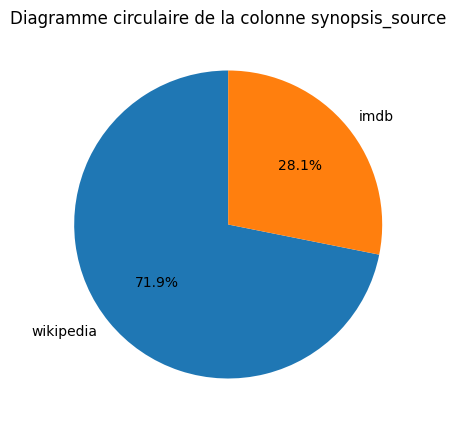

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
dataset['synopsis_source'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Diagramme circulaire de la colonne synopsis_source')
plt.ylabel('')  # Supprimer le label y
plt.show()

Regardons combien il y a de tags au total et quels sont les plus fréquents :

In [ ]:
colonnes_tags = dataset.columns[dataset.columns.get_loc('tags_list') + 1:]

print('Il y a ', len(colonnes_tags), ' tags différents')

Il y a  71  tags différents


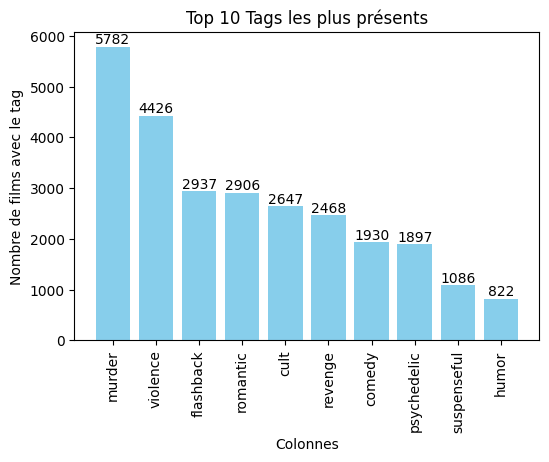

In [ ]:
# Somme des valeurs pour chaque colonne
somme_par_colonne = dataset[colonnes_tags].sum(axis=0)

top_10_colonnes = somme_par_colonne.nlargest(10)

plt.figure(figsize=(6, 4))
bars = plt.bar(top_10_colonnes.index, top_10_colonnes, color='skyblue')

# Ajoutez les annotations pour afficher les valeurs sur chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Top 10 Tags les plus présents')
plt.xlabel('Colonnes')
plt.ylabel('Nombre de films avec le tag')
plt.show()

## Ajout de la date de sortie du film pour différencier les films ayant le même titre

In [ ]:
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

tmp = []
iterList = 0

for index, row in dataset.iterrows():

    id = row['imdb_id']
    title = row['title']

    if doublons_dans_colonne[iterList]:

        print(title)
        print("id : " + str(iterList))

        # URL de la page web que vous souhaitez extraire
        url = "https://www.imdb.com/title/"+str(id)

        # Envoi d'une requête pour récupérer le contenu de la page
        response = requests.get(url)

        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers)


        # Vérification du statut de la requête
        if response.status_code == 200:

            # Analyse du HTML avec BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')

            # Recherche de tous les éléments <a> avec la classe "ipc-link" et d'autres attributs spécifiques
            elements = soup.find_all('a', class_='ipc-link ipc-link--baseAlt ipc-link--inherit-color')

            tmpElem = None
            # Affichage du contenu de chaque élément extrait
            for element in elements:
                if "releaseinfo" in element['href']:
                    tmpElem = int(element.text[:4])
                    print("year : " + element.text[:4])     # Affiche le texte à l'intérieur de la balise <a>
            if tmpElem == None:
                print(id+"here here here here here here here here here here here here here here here here here here ")
            tmp.append(tmpElem)

        else:
            print(f"Erreur de requête: {response.status_code}")
            tmp.append(None)
            print(0)
    else:
        tmp.append(None)

    iterList += 1

In [ ]:
import csv

drive.mount('/content/gdrive')


# Spécifiez le chemin du fichier CSV
csv_file_path = '/content/gdrive/MyDrive/ING3/NLP/Project/listTemp.csv'

# Écrivez la liste dans le fichier CSV
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(tmp)

In [ ]:
dataset['Year'] = ""

iterMovie = 0
iterDoublon = 0
print(len(tmp))

for i in dataset['Year']:
  if doublons_dans_colonne[iterMovie]:
    print(iterMovie)
    print(iterDoublon)
    i = tmp[iterDoublon]
    print(i)
    iterDoublon += 1
  iterMovie += 1

## Sauvegarde du dataframe preprocessé

In [ ]:
dataset.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,synopsis_treebank,synopsis_spacy,tags_list,synopsis_preprocessed_spacy,...,blaxploitation,whimsical,intrigue,allegory,antiwar,avantgarde,suicidal,magicalrealism,nonfiction,year
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,"['Note', ':', 'this', 'synopsis', 'is', 'for',...","['Note', ':', 'this', 'synopsis', 'is', 'for',...","['cult', ' horror', ' gothic', ' murder', ' at...","['note', 'synopsis', 'orginal', 'italian', 're...",...,0,0,0,0,0,0,0,0,0,NaN
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,"['Two', 'thousand', 'years', 'ago', ',', 'Nhag...","['Two', 'thousand', 'years', 'ago', ',', 'Nhag...",['violence'],"['thousand', 'years', 'ago', 'nhagruul', 'foul...",...,0,0,0,0,0,0,0,0,0,NaN
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,"['Matuschek', ""'s"", ',', 'a', 'gift', 'store',...","['Matuschek', ""'s"", ',', 'a', 'gift', 'store',...",['romantic'],"['matuschek', 'gift', 'store', 'budapest', 'wo...",...,0,0,0,0,0,0,0,0,0,NaN
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,"['Glenn', 'Holland', ',', 'not', 'a', 'morning...","['Glenn', 'Holland', ',', 'not', 'a', 'morning...","['inspiring', ' romantic', ' stupid', ' feel-g...","['glenn', 'holland', 'morning', 'person', 'sta...",...,0,0,0,0,0,0,0,0,0,NaN
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,"['In', 'May', '1980', ',', 'a', 'Cuban', 'man'...","['In', 'May', '1980', ',', 'a', 'Cuban', 'man'...","['cruelty', ' murder', ' dramatic', ' cult', '...","['cuban', 'man', 'named', 'tony', 'montana', '...",...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
# En local
dataset.to_csv('films_dataset.csv', index=False)

# Sur google drive
dataset.to_csv('/content/gdrive/MyDrive/ChatbotFilms/films_dataset.csv', index=False)

## NLP

In [1]:
from google.colab import drive
import pandas as pd

# Chargement du dataframe après preprocessing

drive.mount('/content/gdrive')

dataset = pd.read_csv("/content/gdrive/MyDrive/ChatbotFilms/films_dataset.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

**Méthode 1**

In [3]:
smd1 =  dataset
smd1['tags'] = smd1['tags'].fillna('')
smd1['plot_synopsis'] = smd1['synopsis_preprocessed_spacy'] + smd1['tags']
smd1['plot_synopsis'] = smd1['plot_synopsis'].fillna('')

tf1 = TfidfVectorizer(ngram_range=(1, 2), min_df=0)
tfidf1_matrix = tf1.fit_transform(smd1['plot_synopsis'])

tfidf1_matrix.shape

(14828, 4312180)

**Méthode 2**

In [4]:
smd2 =  dataset
smd2['tags'] = smd2['tags'].fillna('')
smd2['plot_synopsis'] = smd2['synopsis_preprocessed_treebank'] + smd2['tags']
smd2['plot_synopsis'] = smd2['plot_synopsis'].fillna('')

tf2 = TfidfVectorizer(ngram_range=(1, 2), min_df=0)
tfidf2_matrix = tf2.fit_transform(smd2['plot_synopsis'])

tfidf2_matrix.shape

(14828, 4314950)

**Calcul de la distance avec la similarité du cosinus pour le synopsis**


In [5]:
cosine_sim1 = linear_kernel(tfidf1_matrix, tfidf1_matrix)
cosine_sim2 = linear_kernel(tfidf2_matrix, tfidf2_matrix)

In [6]:
smd = smd1.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [7]:
def get_recommendations(cosine_sim, title):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    if isinstance(sim_scores[0][1], float):
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      x=1
    else:
      idx = idx[0]
      sim_scores = list(enumerate(cosine_sim[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      x=0
    sim_scores = sim_scores[x:31]
    movie_indices = [i[0] for i in sim_scores]

    selected_movies = smd.iloc[movie_indices].apply(lambda x: {'title': x['title'], 'year': int(x['year'])} if pd.notna(x['year']) else {'title': x['title']}, axis=1).head(10)
    selected_movies_list = selected_movies.tolist()

    return selected_movies_list

In [8]:
get_recommendations(cosine_sim1, 'Dungeons & Dragons')

[{'title': 'Dungeons & Dragons'},
 {'title': 'Dungeons & Dragons', 'year': 1983},
 {'title': 'Diary of the Dead'},
 {'title': 'Anderusen dôwa ningyo-hime'},
 {'title': 'Átame!'},
 {'title': 'Me Without You'},
 {'title': "The Mirror Crack'd"},
 {'title': 'Buffalo Soldiers', 'year': 1997},
 {'title': 'Buffalo Soldiers'},
 {'title': 'To the Wonder'}]

In [9]:
smd = smd2.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

get_recommendations(cosine_sim2, 'Dungeons & Dragons')

[{'title': 'Dungeons & Dragons'},
 {'title': 'Dungeons & Dragons', 'year': 1983},
 {'title': 'Diary of the Dead'},
 {'title': 'Anderusen dôwa ningyo-hime'},
 {'title': 'Átame!'},
 {'title': 'Me Without You'},
 {'title': "The Mirror Crack'd"},
 {'title': 'Buffalo Soldiers', 'year': 1997},
 {'title': 'Buffalo Soldiers'},
 {'title': 'To the Wonder'}]

## LLM

Nous avons choisi de travailler avec GPT-2 et Flan-T5 pour la partie conversationnelle. Ainsi, on le laisse discuter avec l'utilisateur, et lorsqu'un mot clé du champ lexical des films ou de recommandation apparaît, on récupère les tags et le synopsis et on renvoie une liste de films correspondant à la demande de l'utilisateur.

Avec GPT-2 :

In [10]:
# Installation des bibliothèques
!pip install transformers

# Importation des modules
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Chargement du modèle et du tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)


# Fonction pour générer du texte
def generate_response(prompt, model, tokenizer, max_length=50, num_beams=20, no_repeat_ngram_size=2, top_k=50, top_p=1, temperature=0.5):
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    attention_mask = inputs.ne(tokenizer.pad_token_id).float()
    outputs = model.generate(inputs, max_length=max_length, num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size, top_k=top_k, top_p=top_p, temperature=temperature, do_sample=True, attention_mask=attention_mask)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = generated_text.split("\n")[1:]
    generated_text = "".join(generated_text)
    return generated_text

In [13]:
# Début de la discussion
user_input = ""
while True:
    user_input = input("Entrez votre message : ")

    # Pour terminer le chat
    if "exit" in user_input.lower() or "bye" in user_input.lower():
        print("Bot: Bye.")
        break

    # Recomendation de film
    if ("recommend" in user_input.lower() or "give" in user_input.lower()) and ("film" in user_input.lower() or "movie" in user_input.lower()):
            response = "Here is a list of movies you could like, based on your preferences: "
            film = user_input.split("'")[1]
            if len(dataset[dataset['title'] == film] != 0):
              films = get_recommendations(cosine_sim1, film)
              res = ""
              for film in films :
                if 'year' in film:
                  if film == films[len(films)-1]:
                    res+=film['title']+" ("+str(film['year'])+")"
                  else:
                    res=res+film['title']+" ("+str(film['year'])+"), "
                else:
                  if film == films[len(films)-1]:
                    res+=film['title']
                  else:
                    res=res+film['title']+", "
              response = response+res
            else:
              response = "Sorry we don't have " + film + " in our database."
    else:
      response = generate_response(user_input, model, tokenizer)
    print("Bot:", response)


Entrez votre message : Hi do you like pizza?
Bot: I do, but I don't like it. I'm not a big fan of pizza. It's not my thing, and I think it's a waste of time and money. But I do love pizza
Entrez votre message : Can you give me a film like 'Titanic'?
Bot: Here is a list of movies you could like, based on your preferences: Titanic, Titanic (2012), Titanic (1953), Titanic (1943), State of Play, Crazy, Stupid, Love., East of Eden, The Ballad of Jack and Rose, Shank, Shank (2010)
Entrez votre message : Thanks, bye
Bot: Bye.


Avec Flan-T5 :

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Import du modèle Flan-T5
flan_t5_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
flan_t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def post_process_flan_t5(response):
    # Supprimez les tokens spéciaux et les avertissements du modèle
    cleaned_response = response.replace("<pad>", "").replace("</s>", "").strip()
    return cleaned_response

In [ ]:
while True:
    user_input = input("Entrez votre message : ")

    # Pour terminer le chat
    if "exit" in user_input.lower() or "bye" in user_input.lower():
        print("Bot: Bye.")
        break

    # Recomendation de film
    if ("recommend" in user_input.lower() or "give" in user_input.lower()) and ("film" in user_input.lower() or "movie" in user_input.lower()):
            response = "Here is a list of movies you could like, based on your preferences: "
            film = user_input.split("'")[1]
            if len(dataset[dataset['title'] == film] != 0):
              films = get_recommendations(cosine_sim2, film)
              res = ""
              for film in films :
                if 'year' in film:
                  if film == films[len(films)-1]:
                    res+=film['title']+" ("+str(film['year'])+")"
                  else:
                    res=res+film['title']+" ("+str(film['year'])+"), "
                else:
                  if film == films[len(films)-1]:
                    res+=film['title']
                  else:
                    res=res+film['title']+", "
              response = response+res
            else:
              response = "Sorry we don't have " + film + " in our database."
    # Réponse normale du modèle
    else:
        inputs = flan_t5_tokenizer(user_input, return_tensors="pt")
        outputs = flan_t5_model.generate(**inputs)
        response = post_process_flan_t5(flan_t5_tokenizer.decode(outputs[0]))

    print("Bot:", response)

# Test :
# Can you recommend me a film similar to 'The Shop Around the Corner'?

Entrez votre message : Hey, how old are you?
Bot: 18
Entrez votre message : Can you recommend me a film similar to 'The Shop Around the Corner'?
Bot: Here is a list of movies you could like, based on your preferences: Alfred the Great, Salmon Fishing in the Yemen, Helium, Dance of the Vampires, The Burning, Legends of the Fall, Die Blechtrommel, The Batman vs. Dracula, The Pillars of the Earth, Careful
Entrez votre message : Thanks, have a nice day, bye
Bot: Bye.
